## Data pipeline

In [1]:
import numpy as np
import pandas as pd
from scipy.signal import resample
import pywt  # For wavelet transform
from wfdb import processing
from scipy.stats import entropy

# Load the Dataset and Remove Classes 2 and 3
dataset_path = 'data/raw/physionet2017.csv'
data = pd.read_csv(dataset_path)

# Extract ECG signals and labels
X = data.iloc[:, :-2].values  # ECG signal columns
y = data.iloc[:, -1].values  # Last column is the label

# Remove rows with labels 2 and 3 (keep only 0 - Normal and 1 - AF)
filtered_data = data[(y == 0) | (y == 1)]
X_filtered = filtered_data.iloc[:, :-2].values
y_filtered = filtered_data.iloc[:, -1].values

c:\Users\yashv\.conda\envs\tf\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# 1. Resample the ECG Signal (to ensure all signals have the same sampling rate)
def resample_signal(ecg_signal, target_fs=300, original_fs=500):
    num_samples = int(len(ecg_signal) * target_fs / original_fs)
    return resample(ecg_signal, num_samples)

In [3]:
# 2. Use DWT to Denoise the ECG Signal
def dwt_denoise(ecg_signal, wavelet='db4', level=4):
    coeffs = pywt.wavedec(ecg_signal, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745  # Estimate noise level
    uthresh = sigma * np.sqrt(2 * np.log(len(ecg_signal)))
    
    # Apply soft thresholding to denoise
    denoised_coeffs = [pywt.threshold(c, value=uthresh, mode='soft') for c in coeffs]
    return pywt.waverec(denoised_coeffs, wavelet)

In [4]:
# 3. Extract PQRS Complexes Around R-Peaks
def extract_pqrs_complexes(ecg_signal, fs=300, window_size=200):
    try:
        r_peaks = processing.gqrs_detect(sig=ecg_signal, fs=fs)
    except Exception as e:
        print(f"R-peak detection error for signal: {e}")
        return np.zeros((1, window_size))  # Return zeros if R-peak detection fails

    pqrs_complexes = []
    for peak in r_peaks:
        start = max(0, peak - window_size // 2)
        end = min(len(ecg_signal), peak + window_size // 2)
        pqrs_complex = ecg_signal[start:end]
        # Pad if the length of the extracted PQRS complex is less than the window size
        if len(pqrs_complex) < window_size:
            pqrs_complex = np.pad(pqrs_complex, (0, window_size - len(pqrs_complex)), 'constant')
        pqrs_complexes.append(pqrs_complex)
    return np.array(pqrs_complexes)

In [5]:
# 4. Extract R-R Intervals for Each ECG Signal
def calculate_r_r_intervals(ecg_signal, fs=300):
    try:
        r_peaks = processing.gqrs_detect(sig=ecg_signal, fs=fs)
        r_r_intervals = np.diff(r_peaks) / fs  # Calculate intervals between R-peaks
        return r_r_intervals
    except Exception as e:
        print(f"R-R interval error: {e}")
        return np.zeros(1)  # Return zeros if R-R interval calculation fails

In [6]:
# 5. Handcrafted Feature 1: Wavelet Variance
def calculate_wavelet_variance(ecg_signal, wavelet='db4'):
    coeffs = pywt.wavedec(ecg_signal, wavelet, level=4)
    return np.var(coeffs[0])  # Variance of the approximation coefficients

# 6. Handcrafted Feature 2: Shannon Entropy
def calculate_entropy(ecg_signal):
    pd_signal = np.histogram(ecg_signal, bins=100)[0]
    return entropy(pd_signal)

In [7]:
# 7. Standardize the Length of the R-R Intervals (Padding or Truncating)
def standardize_r_r_intervals(r_r_intervals, max_length=20):
    if len(r_r_intervals) < max_length:
        return np.pad(r_r_intervals, (0, max_length - len(r_r_intervals)), 'constant')
    else:
        return r_r_intervals[:max_length]

In [8]:
import numpy as np

# Full preprocessing for each signal
def preprocess_signal(ecg_signal, fs=300, original_fs=500, window_size=200, max_rr_length=20):
    # Resample the signal
    resampled_signal = resample_signal(ecg_signal, target_fs=fs, original_fs=original_fs)
    # Apply DWT for denoising
    denoised_signal = dwt_denoise(resampled_signal)
    # Extract PQRS complexes
    pqrs_complexes = extract_pqrs_complexes(denoised_signal, fs=fs, window_size=window_size)
    # Extract and standardize R-R intervals
    r_r_intervals = calculate_r_r_intervals(denoised_signal, fs=fs)
    standardized_r_r = standardize_r_r_intervals(r_r_intervals, max_length=max_rr_length)
    # Calculate handcrafted features
    wavelet_var = calculate_wavelet_variance(denoised_signal)
    signal_entropy = calculate_entropy(denoised_signal)
    return pqrs_complexes, standardized_r_r, wavelet_var, signal_entropy

# Function to standardize PQRS complexes to a fixed number of complexes and length per complex
def standardize_pqrs_complexes(pqrs_complexes_list, max_complexes=30, window_size=200):
    standardized_pqrs_complexes = []
    
    for pqrs_complexes in pqrs_complexes_list:
        # Ensure pqrs_complexes is at least 2D
        if pqrs_complexes.ndim == 1:
            pqrs_complexes = pqrs_complexes.reshape(1, -1)
        
        # If the number of PQRS complexes exceeds the max number, truncate
        if pqrs_complexes.shape[0] > max_complexes:
            pqrs_complexes = pqrs_complexes[:max_complexes]
        # If fewer complexes than max, pad with zeros
        elif pqrs_complexes.shape[0] < max_complexes:
            pqrs_complexes = np.pad(pqrs_complexes, ((0, max_complexes - pqrs_complexes.shape[0]), (0, 0)), 'constant')
        
        # Ensure each PQRS complex has the fixed window size (padding if necessary)
        if pqrs_complexes.shape[1] < window_size:
            pqrs_complexes = np.pad(pqrs_complexes, ((0, 0), (0, window_size - pqrs_complexes.shape[1])), 'constant')
        
        standardized_pqrs_complexes.append(pqrs_complexes)
    
    return np.array(standardized_pqrs_complexes)

# Apply preprocessing to the entire dataset
X_pqrs = []
X_rr = []
X_wavelet_var = []
X_entropy = []

for ecg_signal in X_filtered:
    pqrs_complexes, r_r_intervals, wavelet_var, signal_entropy = preprocess_signal(ecg_signal)
    X_pqrs.append(pqrs_complexes)
    X_rr.append(r_r_intervals)
    X_wavelet_var.append(wavelet_var)
    X_entropy.append(signal_entropy)

# Standardize PQRS complexes to ensure consistent shape
X_pqrs_standardized = standardize_pqrs_complexes(X_pqrs)

# Convert other features to NumPy arrays
X_rr = np.array(X_rr)
X_wavelet_var = np.array(X_wavelet_var).reshape(-1, 1)  # Handcrafted feature as additional input
X_entropy = np.array(X_entropy).reshape(-1, 1)  # Handcrafted feature as additional input

# Final combined dataset for training
X_combined = np.hstack((X_pqrs_standardized.reshape(len(X_pqrs_standardized), -1), X_rr, X_wavelet_var, X_entropy))

print(f"Shape of PQRS Complexes: {X_pqrs_standardized.shape}")
print(f"Shape of R-R Intervals: {X_rr.shape}")
print(f"Shape of Wavelet Variance Feature: {X_wavelet_var.shape}")
print(f"Shape of Entropy Feature: {X_entropy.shape}")
print(f"Shape of Combined Input: {X_combined.shape}")

Shape of PQRS Complexes: (5834, 30, 200)
Shape of R-R Intervals: (5834, 20)
Shape of Wavelet Variance Feature: (5834, 1)
Shape of Entropy Feature: (5834, 1)
Shape of Combined Input: (5834, 6022)


In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

# Updated ResNet Block with more complexity
def resnet_block(input_data, filters, kernel_size=3, stride=1, dropout_rate=0.3, l2_lambda=0.001):
    # First convolution block
    x = layers.Conv1D(filters=filters, kernel_size=kernel_size, strides=stride, padding='same',
                      kernel_regularizer=regularizers.l2(l2_lambda))(input_data)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Second convolution block
    x = layers.Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='same',
                      kernel_regularizer=regularizers.l2(l2_lambda))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Third convolution block for added depth
    x = layers.Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='same',
                      kernel_regularizer=regularizers.l2(l2_lambda))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Shortcut connection
    shortcut = layers.Conv1D(filters=filters, kernel_size=1, strides=stride, padding='same',
                             kernel_regularizer=regularizers.l2(l2_lambda))(input_data)
    shortcut = layers.BatchNormalization()(shortcut)

    # Add shortcut and main path
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)

    # Optional dropout
    if dropout_rate:
        x = layers.Dropout(dropout_rate)(x)

    return x

In [10]:
# Transformer Encoder Block with Dual Attention
def transformer_encoder_dual(inputs, head_size, num_heads, ff_dim, dropout=0.3):
    # Multi-head attention for R-R intervals
    attention_rr = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs[0], inputs[0])
    attention_rr = layers.LayerNormalization(epsilon=1e-6)(attention_rr)
    attention_rr = layers.Add()([attention_rr, inputs[0]])
    
    # Multi-head attention for PQRS complexes
    attention_pqrs = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs[1], inputs[1])
    attention_pqrs = layers.LayerNormalization(epsilon=1e-6)(attention_pqrs)
    attention_pqrs = layers.Add()([attention_pqrs, inputs[1]])

    # Manually broadcast R-R intervals to match PQRS shape (tile the tensor)
    expanded_rr = tf.tile(attention_rr, [1, inputs[1].shape[1], 1])  # Tile R-R intervals along the time steps

    # Combine both attention blocks (RR and PQRS)
    combined_attention = layers.Concatenate()([expanded_rr, attention_pqrs])

    # Feedforward network after attention
    x_ff = layers.Dense(ff_dim, activation="relu")(combined_attention)
    x_ff = layers.Dropout(dropout)(x_ff)
    
    # Project back to the combined feature dimension of concatenated inputs (192 features)
    x_ff = layers.Dense(combined_attention.shape[-1])(x_ff)  # Project back to combined feature size (192)
    
    x_ff = layers.LayerNormalization(epsilon=1e-6)(x_ff)
    return layers.Add()([x_ff, combined_attention])

In [11]:
# Define the Complete Model
def build_combined_model(pqrs_input_shape, rr_input_shape):
    # PQRS Complex Feature Extraction using ResNet
    pqrs_input = layers.Input(shape=pqrs_input_shape, name="PQRS_Input")
    x_pqrs = resnet_block(pqrs_input, filters=64, kernel_size=3, dropout_rate=0.3)
    x_pqrs = resnet_block(x_pqrs, filters=128, kernel_size=3, dropout_rate=0.3)  # Additional ResNet block for complexity
    
    # Reshape pqrs features into 3D tensor (batch_size, seq_length, feature_dim)
    pqrs_features = layers.Reshape((pqrs_input_shape[0], -1))(x_pqrs)

    # R-R Interval Feature Processing
    rr_input = layers.Input(shape=rr_input_shape, name="RR_Interval_Input")
    rr_dense = layers.Dense(64, activation="relu")(rr_input)
    rr_dense = layers.Reshape((1, 64))(rr_dense)  # Reshape to (batch_size, 1, 64) for compatibility

    # Transformer with Dual Attention for PQRS Complexes and R-R Intervals
    transformer_output = transformer_encoder_dual([rr_dense, pqrs_features], head_size=64, num_heads=4, ff_dim=128, dropout=0.3)

    # Fully Connected Layer for Classification
    x = layers.Flatten()(transformer_output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)  # Dropout to prevent overfitting
    output = layers.Dense(1, activation='sigmoid')(x)  # Binary classification: Normal vs AF

    # Build and Compile Model
    model = models.Model(inputs=[rr_input, pqrs_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
    return model

In [12]:
# Define input shapes for R-R intervals and PQRS complexes
pqrs_input_shape = (30, 200)  # PQRS complexes shape from your dataset
rr_input_shape = (20,)  # R-R interval shape from your dataset

# Build the model
combined_model = build_combined_model(pqrs_input_shape, rr_input_shape)

combined_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 PQRS_Input (InputLayer)        [(None, 30, 200)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 30, 64)       38464       ['PQRS_Input[0][0]']             
                                                                                                  
 batch_normalization (BatchNorm  (None, 30, 64)      256         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 30, 64)       0           ['batch_normalization[0][0]']

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import os
import matplotlib.pyplot as plt

# Assuming X_combined is the prepared dataset and y_filtered contains the labels
# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_combined, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered)

# Further split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Compute class weights for handling imbalance in the dataset
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Create directory to save model checkpoints
checkpoint_dir = './model_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint(filepath=os.path.join(checkpoint_dir, 'best_model.h5'), 
                                   monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Define input shapes for R-R intervals and PQRS complexes
pqrs_input_shape = (30, 200)  # PQRS complexes shape from your dataset
rr_input_shape = (20,)         # R-R interval shape from your dataset

# Build the model
combined_model = build_combined_model(pqrs_input_shape, rr_input_shape)

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=1e-4)
combined_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

# Prepare the input data for the model
# Separate PQRS complexes and R-R intervals
X_pqrs_train = X_train[:, :6000].reshape(-1, 30, 200)  # PQRS complexes
X_rr_train = X_train[:, 6000:6200]                     # R-R intervals

X_pqrs_val = X_val[:, :6000].reshape(-1, 30, 200)      # Validation PQRS complexes
X_rr_val = X_val[:, 6000:6200]                          # Validation R-R intervals

# Ensure that R-R intervals are padded or truncated to a fixed length of 20
def pad_r_intervals(r_intervals, max_length=20):
    if len(r_intervals) < max_length:
        return np.pad(r_intervals, (0, max_length - len(r_intervals)), 'constant')
    return r_intervals[:max_length]

# Apply padding to training and validation R-R intervals
X_rr_train = np.array([pad_r_intervals(interval) for interval in X_rr_train])
X_rr_val = np.array([pad_r_intervals(interval) for interval in X_rr_val])

In [14]:
# Train the model
history = combined_model.fit(
    [X_rr_train, X_pqrs_train],  # Input data
    y_train,
    validation_data=(
        [X_rr_val, X_pqrs_val],  # Validation data
        y_val
    ),
    epochs=100,
    batch_size=32,
    class_weight=class_weight_dict,  # Use class weights to address class imbalance
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    verbose=1
)

Epoch 1/100
146/146 [==============================] - ETA: 0s - loss: 1.6215 - accuracy: 0.5629 - auc: 0.5841
Epoch 1: val_loss improved from inf to 1.14667, saving model to ./model_checkpoints\best_model.h5
146/146 [==============================] - 12s 21ms/step - loss: 1.6215 - accuracy: 0.5629 - auc: 0.5841 - val_loss: 1.1467 - val_accuracy: 0.8611 - val_auc: 0.6844 - lr: 1.0000e-04
Epoch 2/100
145/146 [============================>.] - ETA: 0s - loss: 1.4193 - accuracy: 0.6394 - auc: 0.6657
Epoch 2: val_loss improved from 1.14667 to 1.13044, saving model to ./model_checkpoints\best_model.h5
146/146 [==============================] - 2s 16ms/step - loss: 1.4188 - accuracy: 0.6402 - auc: 0.6666 - val_loss: 1.1304 - val_accuracy: 0.8525 - val_auc: 0.7458 - lr: 1.0000e-04
Epoch 3/100
145/146 [============================>.] - ETA: 0s - loss: 1.3566 - accuracy: 0.6886 - auc: 0.7404
Epoch 3: val_loss improved from 1.13044 to 1.12205, saving model to ./model_checkpoints\best_model.h5
14

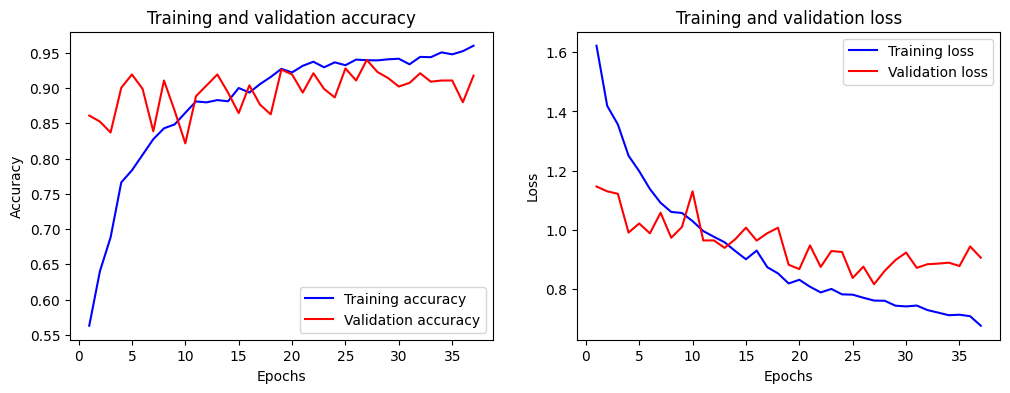

In [15]:
# Plot training and validation loss and accuracy
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot the training history
plot_training_history(history)

19/19 [==============================] - 0s 7ms/step


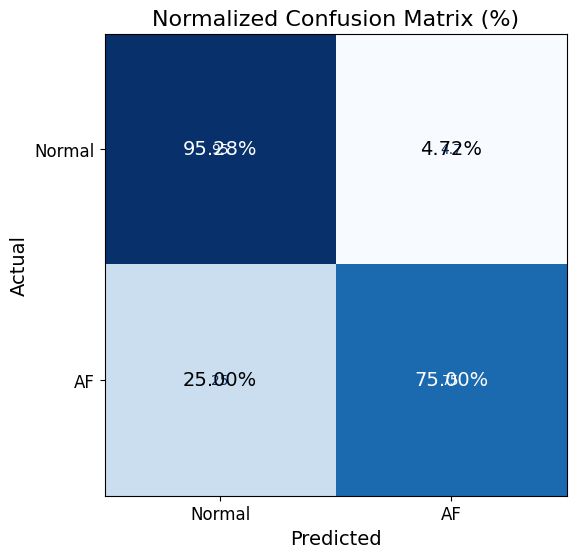

              precision    recall  f1-score   support

      Normal       0.96      0.95      0.96       508
          AF       0.70      0.75      0.73        76

    accuracy                           0.93       584
   macro avg       0.83      0.85      0.84       584
weighted avg       0.93      0.93      0.93       584



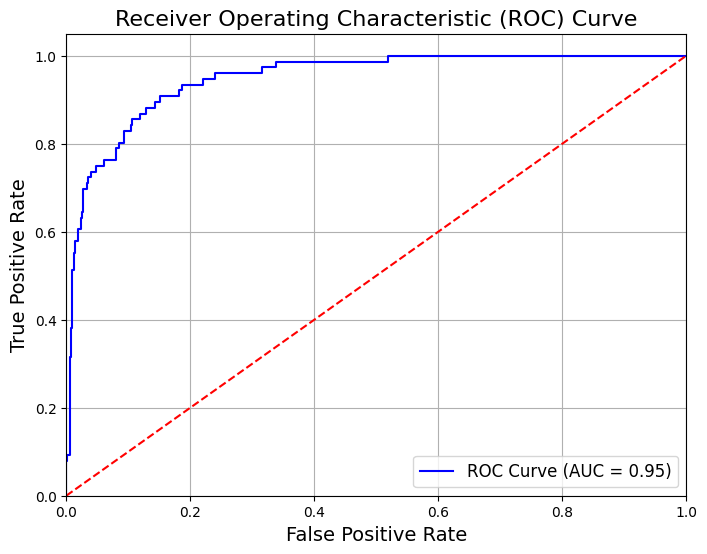

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay

# Evaluate the model on the test set
X_pqrs_test = X_test[:, :6000].reshape(-1, 30, 200)  # Test PQRS complexes
X_rr_test = X_test[:, 6000:6200]                     # Test R-R intervals

# Ensure that R-R intervals are padded or truncated to a fixed length of 20
X_rr_test = np.array([pad_r_intervals(interval) for interval in X_rr_test])

# Make predictions
y_pred_probs = combined_model.predict([X_rr_test, X_pqrs_test])  # Get predicted probabilities
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary predictions

# Function to normalize the confusion matrix
def normalize_confusion_matrix(cm):
    return cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Normalize by row (true class)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_normalized = normalize_confusion_matrix(cm)  # Normalize to get percentages

# Display confusion matrix
plt.figure(figsize=(8, 6), dpi=100)  # Increased DPI for better quality
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=["Normal", "AF"])
cm_display.plot(cmap=plt.cm.Blues, ax=plt.gca(), colorbar=False)  # Display without colorbar

# Annotate the matrix with percentage values
for (i, j), val in np.ndenumerate(cm_normalized):
    plt.text(j, i, f'{val:.2f}%', ha='center', va='center', fontsize=14, color='white' if val > 50 else 'black')

plt.title("Normalized Confusion Matrix (%)", fontsize=16)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Print Classification Report
print(classification_report(y_test, y_pred, target_names=["Normal", "AF"]))

# AUC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
auc_score = roc_auc_score(y_test, y_pred_probs)

plt.figure(figsize=(8, 6), dpi=100)
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid()
plt.show()